In [443]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [444]:
# using the Apple metal framework to move tensors to GPU
torch.backends.mps.is_available()

True

In [445]:
with open('names.txt','r') as w:
    names = w.read()
    names = names.splitlines()

In [446]:
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [447]:
len(names)

32033

In [448]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos= {s:i for i,s in stoi.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [449]:
block_size = 3

x, y = [], []

for w in names:
    
    # print(w)

    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)

        # print(''.join(itos[i] for i in context),'--->',itos[ix])

        context = context[1:] + [ix]

x = torch.tensor(x)
y = torch.tensor(y)

In [450]:
def build_dataset(words):
    block_size = 3 #context length / how many chars do we need to predict the next word
    x, y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape,y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(names)

n1 = int(0.7*len(names))
n2 = int(0.9*len(names))

xtr, ytr = build_dataset(names[:n1])
xdev, ydev = build_dataset(names[n1:n2])
xtest, ytest = build_dataset(names[n2:])

torch.Size([159846, 3]) torch.Size([159846])
torch.Size([45434, 3]) torch.Size([45434])
torch.Size([22866, 3]) torch.Size([22866])


In [451]:
len(names),n1,n2

(32033, 22423, 28829)

In [452]:
x[:4],y[:4]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13]]),
 tensor([ 5, 13, 13,  1]))

Now we embedd our 27 characters into a 2-D space.

In [453]:
C = torch.randn((27,2))

### Below we do some tensor gymnastics to see how effective pytorch indexing is and how we can simply index into C from x using C[x].

In [454]:
x[:2], x[:2].shape

(tensor([[0, 0, 0],
         [0, 0, 5]]),
 torch.Size([2, 3]))

In [455]:
x[13,2]

tensor(1)

In [456]:
C[x[13]][2]

tensor([0.5349, 1.3570])

In [457]:
C[1]

tensor([0.5349, 1.3570])

In [458]:
C[[1,2,3]]

tensor([[ 0.5349,  1.3570],
        [-0.2758,  0.4830],
        [ 0.7167, -1.0789]])

In [459]:
C[x[:2]], C[x[:2]].shape

(tensor([[[ 0.8900, -1.0864],
          [ 0.8900, -1.0864],
          [ 0.8900, -1.0864]],
 
         [[ 0.8900, -1.0864],
          [ 0.8900, -1.0864],
          [-0.0655,  0.3430]]]),
 torch.Size([2, 3, 2]))

## Now we implement the embedding lookup table

In [460]:
emb = C[x]
emb.shape

torch.Size([228146, 3, 2])

In [461]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [462]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [463]:
emb.size()

torch.Size([228146, 3, 2])

## To move our inputs to the next layer we would want to do 
1. emb @ W1 + b
2. But, we can't do that as emb and W1 are not shape compatible
3. So we do something familiar, i.e reshape/view of emb

In [464]:
# h = emb.view(32,6) @ W1 + b1 we change this in favour of below, as the magic -1 pops up.
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #also add a tanh to ensure ouputs btw -1 and 1, our non-linearity
h.shape

torch.Size([228146, 100])

In [465]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [466]:
logits = h @ W2 + b2

In [467]:
logits.shape

torch.Size([228146, 27])

In [468]:
counts = logits.exp()

In [469]:
probs = counts / counts.sum (1, keepdim = True)

In [470]:
probs.shape

torch.Size([228146, 27])

In [471]:
#  again why log, if the probability is very high, we get the output close to zero, else if close to zero, we get hugely -ve.
loss = -probs[torch.arange(32),y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

## Lets make it respectable :)

In [472]:
x.shape, y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# intialising all our embeddings, layers and biases
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [ ]:
z = []
for p in parameters:
    z.append(p.numel()) #numel returns the number of elements in the tensor
x,sum(z)

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 3481)

In [474]:
sum(p.numel() for p in parameters)

11897

In [483]:
# forward pass
emb = C[x]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)

## The below is a manual implemenation of negative log-likelihood loss or cross entropy loss, highly inefficient
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32),y].log().mean()

loss = F.cross_entropy(logits,y) # we can always replace the manual implementation of cross entropy with the direct funtion call, as its much faster
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1140730x6 and 30x200)

In [484]:
# enable gradient tracking
for p in parameters:
    p.requires_grad = True

In [485]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [477]:
batch_size = 32
lri = []
lossi = []

In [486]:
for i in range(1):

    # minibatch initialisation
    ix = torch.randint(0,xtr.shape[0],(batch_size,))

    # forward pass
    emb = C[xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits,ytr[ix]) 
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()


    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # # trac stats
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

3.295837163925171


In [492]:
param_names = ['Embedding_lookup','W1','b1','W2','b2']
hyperparams: dict[str, float]
hyperparams = {name:p.shape for name,p in zip(param_names,parameters)}
hyperparams['Total_params'] = sum(p.numel() for p in parameters)
hyperparams['lr'] = lr
hyperparams['context_lenght'] = len(context)
hyperparams['batch_size'] = batch_size
hyperparams

{'Embedding_lookup': torch.Size([27, 10]),
 'W1': torch.Size([30, 200]),
 'b1': torch.Size([200]),
 'W2': torch.Size([200, 27]),
 'b2': torch.Size([27]),
 'Total_params': 11897,
 'lr': 0.1,
 'context_lenght': 3,
 'batch_size': 32}

In [493]:
# training loss
emb = C[xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,ytr)
loss

tensor(3.2958)

In [494]:
# dev loss
emb = C[xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,ydev)
loss

tensor(3.2958)

In [ ]:
lossi

[17.070384979248047,
 22.610342025756836,
 20.64112663269043,
 17.729372024536133,
 19.34000587463379,
 19.333986282348633,
 17.4310302734375,
 20.040176391601562,
 19.171550750732422,
 19.091968536376953,
 18.063207626342773,
 20.743581771850586,
 17.64053726196289,
 21.521209716796875,
 18.28887939453125,
 22.444664001464844,
 18.03293228149414,
 20.586177825927734,
 16.8083438873291,
 20.45482635498047,
 17.229612350463867,
 20.186595916748047,
 20.32685661315918,
 19.778226852416992,
 20.404518127441406,
 18.96505355834961,
 18.19423484802246,
 19.303178787231445,
 21.37774658203125,
 17.87245750427246,
 22.7100887298584,
 16.373493194580078,
 18.33818817138672,
 18.584835052490234,
 15.352697372436523,
 20.25798797607422,
 17.343629837036133,
 16.889328002929688,
 17.439983367919922,
 17.97250747680664,
 18.906658172607422,
 19.585166931152344,
 15.574941635131836,
 21.585689544677734,
 16.618284225463867,
 20.409168243408203,
 18.217153549194336,
 17.785924911499023,
 19.01387023

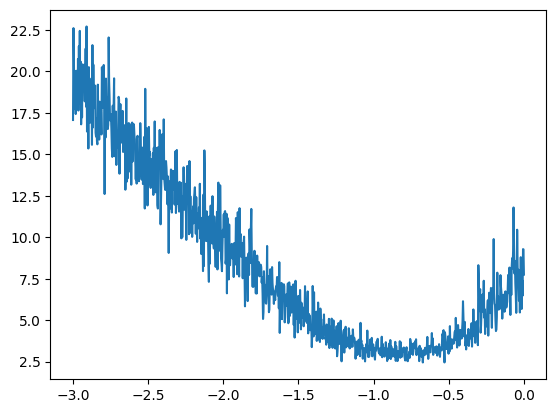

In [ ]:
plt.plot(lri,lossi)
# As we can see that we can find a good learning rate which comes to around -1.0, or 10^-1 = 0.1
# So 0.1 is a good learning rate.

In [ ]:
logits.max(1)[1]

tensor([ 1, 18, 14,  ..., 20,  0,  1])

In [ ]:
ydev

tensor([ 2,  5, 12,  ...,  5, 10,  0])